# Contextual Preference Ranking and Reinforcement Learning for Gin Rummy
### Mykola Zaitsev, k12147393

### Libraries
- We use ***gin_rummy_v4*** environment from *pettingzoo* (more details: https://pettingzoo.farama.org/environments/classic/gin_rummy/)
- *numpy* for operations, *matplotlib* for plotting
- *PyTorch* for Siamese Neural Network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from pettingzoo.classic import gin_rummy_v4

## Data

### Collect winning game data

Simulate num_games (10000) Gin Rummy matches.

- For each turn, the current hand  is extracted.
- At the end of each game, if Player 0 wins, all recorded moves for that game are added to winning_data.
- The collected winning moves are saved as a NumPy file.

In [2]:
def collect_winning_data(num_games=100000):
    env = gin_rummy_v4.env()
    winning_data = []
    
    for _ in range(num_games):
        env.reset()
        game_data = []
        
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            if termination or truncation:
                break
            
            hand = obs['observation'][0][:52] 
            action_mask = obs['action_mask']
            legal_actions = [i for i in range(len(action_mask)) if action_mask[i] == 1]
            
            if not legal_actions:
                env.step(env.action_space(agent).sample())
                continue
            
            chosen_action = random.choice(legal_actions) 
            game_data.append((hand, chosen_action, legal_actions))
            env.step(chosen_action)
        
        if env.rewards['player_0'] > env.rewards['player_1']:
            winning_data.extend(game_data)
    
    np.save("gin_rummy_winning_data.npy", np.array(winning_data, dtype=object), allow_pickle=True)
    print(f"Collected {len(winning_data)} winning moves.")

### Select positive and negative examples

The function loads obtained NumPy file, which contains hands, chosen actions, and legal actions from winning games.

For each game instance:
- The chosen action (used in the winning game) is the positive example.
- A negative example is selected randomly from the remaining legal actions.

The processed dataset, which contains (hand, positive_action, negative_action) tuples, is saved as new NumPy file.

In [3]:
def select_training_examples():
    data = np.load("gin_rummy_winning_data.npy", allow_pickle=True)
    training_data = []
    
    for hand, chosen_action, legal_actions in data:
        negative_candidates = [a for a in legal_actions if a != chosen_action]
        if negative_candidates:
            negative_action = random.choice(negative_candidates)
        else:
            continue
        training_data.append((hand, chosen_action, negative_action))
    
    np.save("gin_rummy_training_data.npy", np.array(training_data, dtype=object), allow_pickle=True)
    print(f"Selected {len(training_data)} positive and negative examples.")

### Define dataset class

NumPy file contains tuples of (Hand representation, Positive action, Negative action). <br>
We convert it to PyTorch tensors. *getitem* method returns the hand, positive action, and negative action for each training instance.

In [4]:
class GinRummyDataset(Dataset):
    def __init__(self, data):
        self.hands = torch.tensor(np.stack([np.array(d[0], dtype=np.float32) for d in data]), dtype=torch.float32)
        self.positive_actions = torch.tensor(np.array([d[1] for d in data], dtype=np.int64), dtype=torch.long)
        self.negative_actions = torch.tensor(np.array([d[2] for d in data], dtype=np.int64), dtype=torch.long)
    
    def __len__(self):
        return len(self.hands)
    
    def __getitem__(self, idx):
        return self.hands[idx], self.positive_actions[idx], self.negative_actions[idx]

In [5]:
collect_winning_data()
select_training_examples()

Collected 5899183 winning moves.
Selected 5800653 positive and negative examples.


## Siamese Neural Network

### Define Siamese Neural Network

**Hand Embedding Layer.** Converts the 52-card hand representation into a 128-dimensional feature vector. Uses ReLU activations and progressively reduces the size to 32 dimensions. <br>
**Action Embedding Layer.** Converts actions (110 possible actions in Gin Rummy environment) into 32-dimensional embeddings.
Uses one-hot encoding before passing it through a ReLU-activated linear layer.

In [14]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.hand_embedding = nn.Sequential(
            nn.Linear(52, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU()
        )
        self.action_embedding = nn.Sequential(
            nn.Linear(110, 32), nn.ReLU()
        )
    
    def forward(self, hand, action_1, action_2):
        hand_embed = self.hand_embedding(hand)
        action_1_embed = self.action_embedding(F.one_hot(action_1, num_classes=110).float())
        action_2_embed = self.action_embedding(F.one_hot(action_2, num_classes=110).float())
        return hand_embed, action_1_embed, action_2_embed

### Define Triplet Loss

**Anchor.** The hand embedding. <br>
**Positive.** The embedding of a positive action. <br>
**Negative.** The embedding of a negative action. <br>

We calculate distance and compute loss. The model is trained so that good moves are consistently closer to the current hand representation than bad moves, by at least the margin.

In [15]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        pos_dist = torch.norm(anchor - positive, p=2, dim=1)
        neg_dist = torch.norm(anchor - negative, p=2, dim=1)
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

### Train SNN with Triplet Loss

In [36]:
def train_snn():
    data = np.load("gin_rummy_training_data.npy", allow_pickle=True)
    dataset = GinRummyDataset(data)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    model = SiameseNetwork()
    criterion = TripletLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(10):
        for hand, pos_action, neg_action in dataloader:
            optimizer.zero_grad()
            anchor, positive, negative = model(hand, pos_action, neg_action)
            loss = criterion(anchor, positive, negative)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    torch.save(model.state_dict(), "gin_rummy_snn.pth")
    print("Model training complete.")

In [37]:
train_snn()

Epoch 1, Loss: 1.0113
Epoch 2, Loss: 0.9176
Epoch 3, Loss: 1.1624
Epoch 4, Loss: 0.9700
Epoch 5, Loss: 1.0385
Epoch 6, Loss: 1.0798
Epoch 7, Loss: 1.0458
Epoch 8, Loss: 1.0797
Epoch 9, Loss: 1.0494
Epoch 10, Loss: 1.1245
Model training complete.


## Evaluation
- Player 0 uses Siamese Neural Network to evaluate card usefulness
- Player 1 uses random policy

In [38]:
rewards_player_0 = []
rewards_player_1 = []
num_episodes = 1000
def evaluate_snn(): 
    env = gin_rummy_v4.env()
    model = SiameseNetwork()
    model.load_state_dict(torch.load("gin_rummy_snn.pth", weights_only=True))
    model.eval()
    
    wins = 0
    for _ in range(num_episodes):
        env.reset()
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            if termination or truncation:
                break
            
            hand = torch.tensor(obs['observation'][0][:52], dtype=torch.float32).unsqueeze(0)
            action_mask = obs['action_mask']
            legal_actions = [i for i in range(len(action_mask)) if action_mask[i] == 1]
            
            if not legal_actions:
                env.step(env.action_space(agent).sample())
                continue
            
            if agent == 'player_0':
                scores = [(a, model(hand, torch.tensor([a]), torch.tensor([random.choice(legal_actions)]) )[0].sum().item()) for a in legal_actions]
                best_action = max(scores, key=lambda x: x[1])[0]
            else:
                best_action = random.choice(legal_actions)
            
            env.step(best_action)
            
        reward_0 = env.rewards["player_0"]
        reward_1 = env.rewards["player_1"]

        rewards_player_0.append(reward_0)
        rewards_player_1.append(reward_1)
        if env.rewards['player_0'] > env.rewards['player_1']:
            wins += 1
    
    print(f"SNN Player Win Rate: {wins/num_episodes * 100}%")

In [39]:
evaluate_snn()

SNN Player Win Rate: 75.3%


### Results
- Number of times Player 0 went Gin (best outcome)
- Win percentage

In [40]:
print("Player 0 went Gin", rewards_player_0.count(1), "times")
print("Player 1 went Gin", rewards_player_1.count(1), "times")

result = [a - b for a, b in zip(rewards_player_0, rewards_player_1)]
print("Win percentage:", (sum(1 for x in result if x > 0))/num_episodes * 100, "%")

Player 0 went Gin 81 times
Player 1 went Gin 0 times
Win percentage: 75.3 %


### Rewards plot

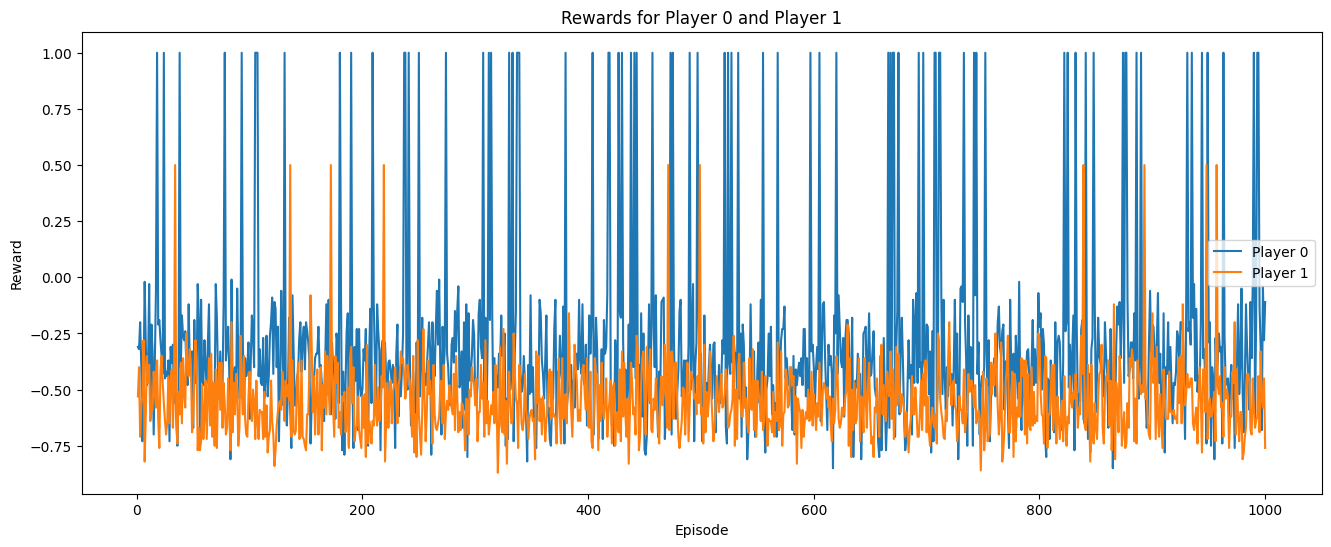

In [41]:
plt.figure(figsize=(16, 6))
plt.plot(range(1, num_episodes + 1), rewards_player_0, label='Player 0')
plt.plot(range(1, num_episodes + 1), rewards_player_1, label='Player 1')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards for Player 0 and Player 1')
plt.legend()
plt.show()